In [72]:
import pandas as pd
import numpy as np
#import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split
import seaborn as sns
import mlflow

In [2]:
sns.__version__

'0.11.2'

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df['TotalCharges'].replace(to_replace = ' ', value = np.nan, inplace = True)


In [6]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [7]:
#stats = tfdv.generate_statistics_from_dataframe(df)

In [8]:
#tfdv.visualize_statistics(stats)

No need to worry about the zeros in 'SeniorCitizen', it is clearly a categorical variable. 

The goal of this project is to track experiments using mlflow and to statistically compare two models. For this reason, we will quickly go through each variable and select those that seem to have an influence on churn in order to simplify training.

## Train Test Split

Even for Data Analysis, we don't want to sneak peak into our test set, so we split before doing anything else. Moreover, since there are very few lines with a null value (less than 1%), we can remove them.

In [9]:
df = df.dropna()

## Data Analysis and Feature Selection

In [10]:
features_to_remove = ['customerID']

<AxesSubplot:xlabel='gender', ylabel='count'>

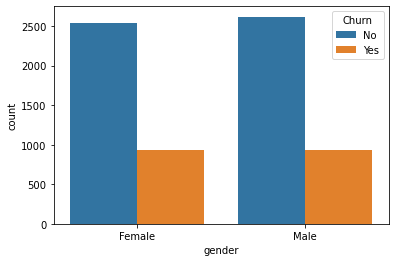

In [11]:
sns.countplot(data = df,x = "gender", hue = "Churn")

In [12]:
# Gender has no influence on churn ratio
features_to_remove.append('gender')

<AxesSubplot:xlabel='Partner', ylabel='count'>

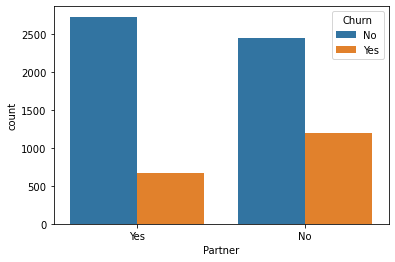

In [13]:
sns.countplot(data = df, x = "Partner", hue = "Churn")

In [14]:
# Clients who have a partner are less likely to churn 

<AxesSubplot:xlabel='Dependents', ylabel='count'>

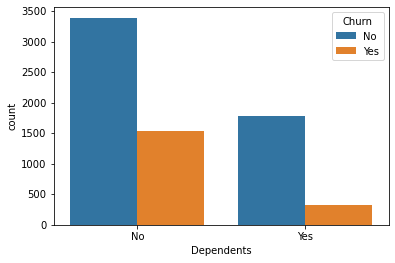

In [15]:
sns.countplot(data = df, x = "Dependents", hue = "Churn")

In [16]:
# Having dependents make clients less likely to churn 

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

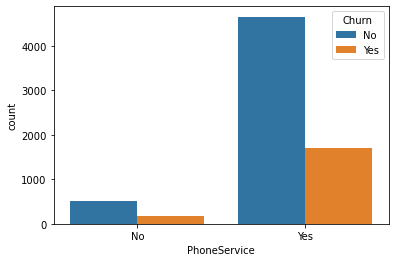

In [17]:
sns.countplot(data = df, x = "PhoneService", hue = "Churn")

In [18]:
ratio_yes = len(df[(df['PhoneService']=='Yes') & (df['Churn']=='Yes')])/len(df[df['PhoneService']=='Yes'])
ratio_no = len(df[(df['PhoneService']=='No') & (df['Churn']=='Yes')])/len(df[df['PhoneService']=='No'])
print(f'Churn ratio No PhoneService = {ratio_no} \nChurn ratio PhoneService = {ratio_yes}')

Churn ratio No PhoneService = 0.25 
Churn ratio PhoneService = 0.26747481108312343


In [19]:
#Little to no influence, removed
features_to_remove.append('PhoneService')

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

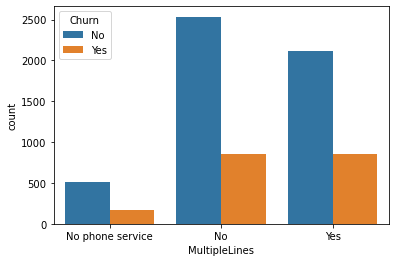

In [20]:
sns.countplot(data = df, x = "MultipleLines", hue = "Churn")

In [21]:
# Does not make much of a difference, remove
features_to_remove.append('MultipleLines')

<AxesSubplot:xlabel='InternetService', ylabel='count'>

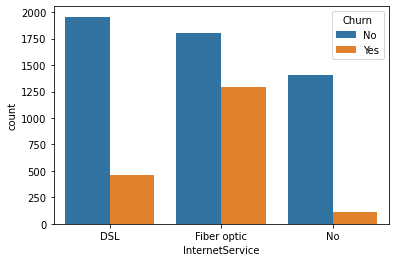

In [22]:
sns.countplot(data = df, x = "InternetService", hue = "Churn")

In [23]:
# Fiber optic clients have a lot higher churn ratio

<AxesSubplot:xlabel='OnlineSecurity', ylabel='count'>

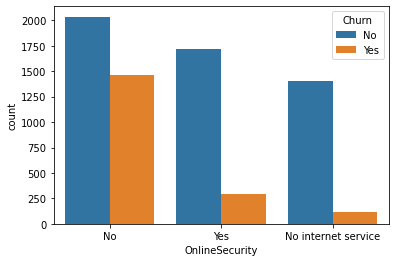

In [24]:
sns.countplot(data = df, x = "OnlineSecurity", hue = "Churn")

In [25]:
# Not having OnlineSecurity increases churn ratio

<AxesSubplot:xlabel='OnlineBackup', ylabel='count'>

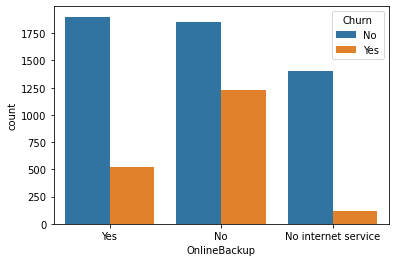

In [26]:
sns.countplot(data = df, x = "OnlineBackup", hue = "Churn")

In [27]:
# Same with online backup

<AxesSubplot:xlabel='DeviceProtection', ylabel='count'>

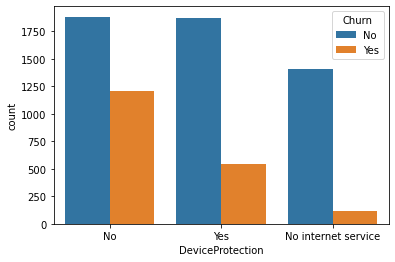

In [28]:
sns.countplot(data = df, x = "DeviceProtection", hue = "Churn")

In [29]:
# Not having device protection increases churn likelyhood

<AxesSubplot:xlabel='TechSupport', ylabel='count'>

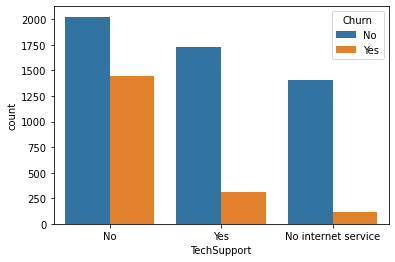

In [30]:
sns.countplot(data = df, x = "TechSupport", hue = "Churn")

In [31]:
# Same with TechSupport

<AxesSubplot:xlabel='StreamingTV', ylabel='count'>

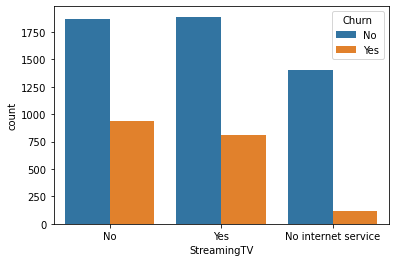

In [32]:
sns.countplot(data = df, x = "StreamingTV", hue = "Churn")

In [33]:
# No big influence among people with internet service, removing feature
features_to_remove.append('StreamingTV')

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

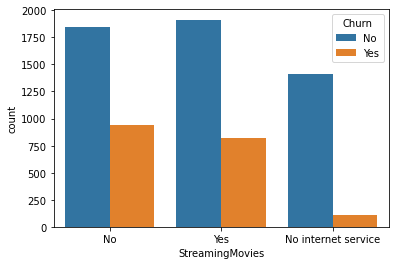

In [34]:
sns.countplot(data = df, x = "StreamingMovies", hue = "Churn")

In [35]:
# No big difference either, removing
features_to_remove.append('StreamingMovies')

<AxesSubplot:xlabel='Contract', ylabel='count'>

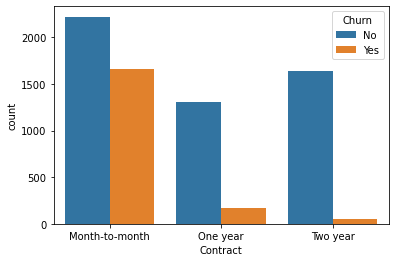

In [36]:
sns.countplot(data = df, x = "Contract", hue = "Churn")

In [37]:
# As expected, people having month-to-month contract are a lot more likely to churn

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

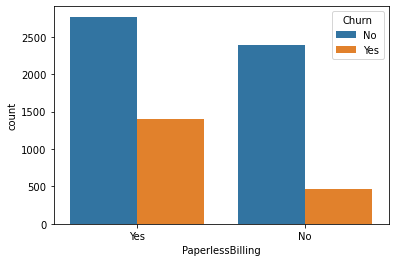

In [38]:
sns.countplot(data = df, x = "PaperlessBilling", hue = "Churn")

In [39]:
# Quite a difference, keeping column

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

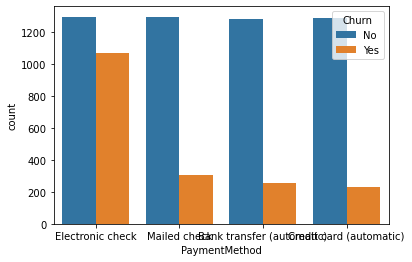

In [40]:
sns.countplot(data = df, x = "PaymentMethod", hue = "Churn")

Electronic check clients are more likely to churn while other methods roughly have the same probability to churn. We will thus group them into a single variable

In [41]:
features_to_remove.append('PaymentMethod')
df['ElectronicCheck'] = df['PaymentMethod'].apply(lambda x : 'Yes' if x == 'Electronic check' else 'No')

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

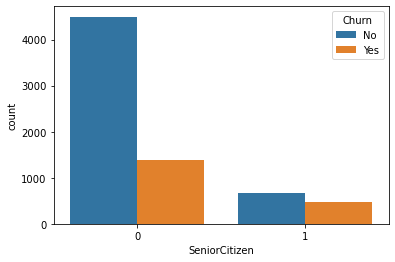

In [42]:
sns.countplot(data = df, x = "SeniorCitizen", hue = "Churn")

In [43]:
# Seniors are more stable and less likely to churn 

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

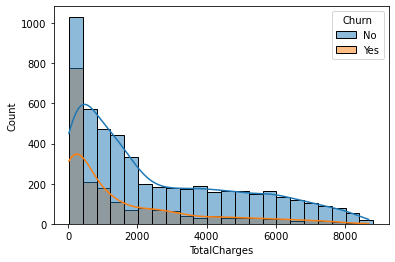

In [44]:
sns.histplot(data=df, x="TotalCharges", binwidth=400,hue='Churn',kde=True)


In [45]:
# Histograms and distributions really look alike, total charge seems to have no influence
features_to_remove.append('TotalCharges')

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

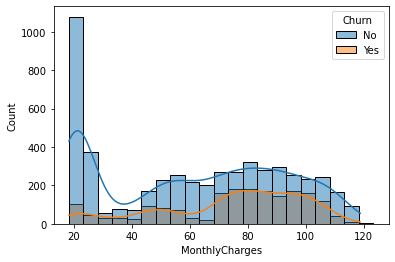

In [46]:
sns.histplot(data=df, x="MonthlyCharges", binwidth=5,hue='Churn',kde=True)


In [47]:
# Low monthly charge churn less often comparatively

<AxesSubplot:xlabel='tenure', ylabel='Count'>

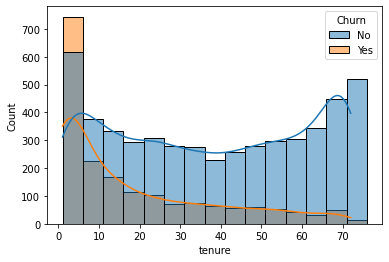

In [48]:
sns.histplot(data=df, x="tenure", binwidth=5,hue='Churn',kde=True)


# Data Preprocessing Pipeline

In [49]:
from sklearn.pipeline import Pipeline

In [50]:
features_to_remove

['customerID',
 'gender',
 'PhoneService',
 'MultipleLines',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod',
 'TotalCharges']

In [51]:
df_selected_features = df.drop(columns=features_to_remove)

## Train Test Split

In [121]:
train, validate, test = \
              np.split(df_selected_features.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [122]:
X_train, y_train, X_val, y_val, X_test, y_test = train.drop(columns=['Churn']), train['Churn'], validate.drop(columns=['Churn']), validate['Churn'], test.drop(columns=['Churn']), test['Churn']

In [123]:
len(X_train)

4219

## Preprocessing Pipeline

In [124]:
all_variables = list(X_train.columns)
numerical_variables = ['MonthlyCharges', 'tenure']
categorical_variables = [var for var in all_variables if var not in numerical_variables]

In [125]:
categorical_variables

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'ElectronicCheck']

In [126]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [127]:
numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())
])

In [128]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numerical_variables)
   ,('categorical', categorical_transformer, categorical_variables)
]) 

In [129]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
           ])

In [130]:
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges', 'tenure']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
         

In [131]:
X_train_preprocessed = pipeline.transform(X_train)
X_val_preprocessed = pipeline.transform(X_val)
X_test_preprocessed = pipeline.transform(X_test)

In [132]:
y_train = y_train.apply(lambda x : int(x == 'Yes'))
y_val = y_val.apply(lambda x : int(x == 'Yes'))
y_test = y_test.apply(lambda x : int(x == 'Yes'))

In [133]:
y_train

2481    0
6784    0
6125    1
3052    0
4099    0
       ..
4993    0
3874    0
6276    0
3053    0
783     1
Name: Churn, Length: 4219, dtype: int64

# Training two models

In this section, we will train two models (RandomForest and SVM), and hypertune them using GridSearch and CrossValidation. Once hyperparameters are tune, we will try to exhibit if the models have a significant statistical difference.

In [116]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [117]:
with mlflow.start_run():
    mlflow.sklearn.log_model(SVC())
    svm.fit(X_train_preprocessed, y_train)
    predictions = svm.predict(X_test_preprocessed)
    

TypeError: log_model() missing 1 required positional argument: 'artifact_path'

In [134]:
svm = SVC()

In [135]:
svm.fit(X_train_preprocessed, y_train)

SVC()

In [136]:
y_pred = svm.predict(X_test_preprocessed)

In [137]:
from sklearn.metrics import confusion_matrix, classification_report

In [138]:
print(confusion_matrix(y_test,y_pred))

[[931  86]
 [179 211]]


In [139]:
rf = RandomForestClassifier()
rf.fit(X_train_preprocessed,y_train)
y_pred_rf = rf.predict(X_test_preprocessed)

In [140]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1017
           1       0.63      0.49      0.55       390

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [163]:
knn = KNeighborsClassifier()
knn.fit(X_train_preprocessed,y_train)
y_pred_knn = knn.predict(X_test_preprocessed)

In [164]:
print(confusion_matrix(y_test,y_pred_knn))

[[448  54]
 [115  87]]


In [165]:
y_test.value_counts()

0    502
1    202
Name: Churn, dtype: int64